In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import math
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import glob
from skimage.transform import resize
from skimage.color import rgb2gray
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from PIL import Image
from skimage.transform import resize
import numpy as np 
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from tqdm import tqdm
from google.colab import drive
import tensorflow as tf
from keras.layers import Input
import random

In [ ]:
drive.mount('/content/drive', force_remount=True)
root =  "/content/drive/My Drive/deep learning/"

Mounted at /content/drive


In [ ]:
path_img,path_mask=[],[]
path_main =  "/content/drive/My Drive/deep learning/"
fold=os.listdir(path_main)
fold.remove('README.md')
fold.remove('data.csv')
for i in fold:
  new_fold = os.path.join(path_main,i)  
  for file in os.listdir(new_fold):
    if "mask" in file:
      path_mask.append(os.path.join(new_fold,file))
    else:
      path_img.append(os.path.join(new_fold,file))

In [ ]:
wm_image=[]
random.shuffle(path_img)
print('Images')
for pimg in tqdm(path_img):
    pimg=pimg.split('.')
    pimg[0]=pimg[0]+'_mask'
    pimg='.'.join(pimg)
    if pimg not in path_mask:
        wm_image.append(pimg)
del path_mask
path_mask=[]
print('Mask')
for pimg in tqdm(path_img): 
    pimg=pimg.split('.')
    pimg[0]=pimg[0]+'_mask'
    pimg='.'.join(pimg)
    path_mask.append(pimg)
if len(wm_image)==0:
    print('\n Checking all images have masks')

Images


100%|██████████| 3929/3929 [00:00<00:00, 10089.44it/s]


Mask


100%|██████████| 3929/3929 [00:00<00:00, 267453.59it/s]


 Checking all images have masks


Random Image from the data

/content/drive/My Drive/deep learning/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_10.tif


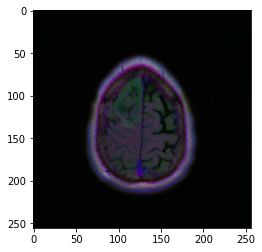

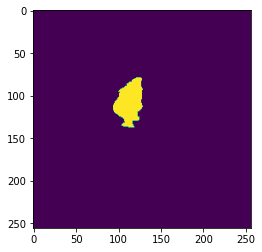

In [ ]:
print(path_img[20])
img = plt.imread(path_img[5])
plt.imshow(img)
plt.show()
mask = plt.imread(path_mask[5])
plt.imshow(mask)
plt.show()

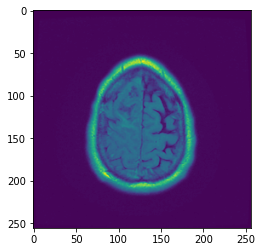

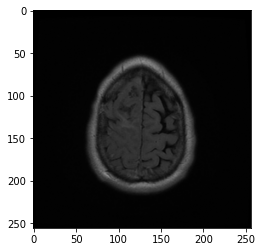

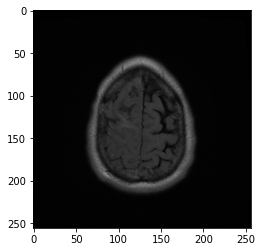

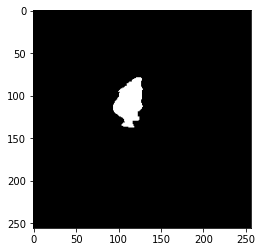

In [ ]:
r_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
z = r_img.astype(float)
z = z/255
plt.imshow(z)
plt.show()
plt.imshow(np.dstack((z,z,z)))
plt.show()
plt.imshow(np.dstack((r_img,r_img,r_img)))
plt.show()
plt.imshow(np.dstack((mask,mask,mask)))
plt.show()

Converting all the Images into Gray Scale Images and reshaping the Gray Scale Image

In [ ]:
imgs, masks = [],[]

count = 0
for path in path_img:
  count+= 1
  if(count % 500 == 0):
    print(count)
  a = plt.imread(path)
  a = (cv2.cvtColor(a, cv2.COLOR_BGR2GRAY))
  imgs.append(a)

for path in path_mask:
  b = plt.imread(path)
  b = b/255
  masks.append(b)

500
1000
1500
2000
2500
3000
3500


Accuracy Function

In [ ]:
def accuracy_fun(masks,predis_tran_t):
  total = 0
  for i in range(len(masks)):
    p_num = 0
    n_num = 0
    p_correct = 0
    n_correct = 0
    for x in range(0,len(masks[i])):
      for j in range(0,len(masks[i][x])):
        if(masks[i][x][j]!=0):
          p_num += 1
          if(preds_train_t[i][x][j]!=0):
            p_correct +=1
        else:
          n_num += 1
          if(preds_train_t[i][x][j]==0):
            n_correct += 1
    if(p_num ==0):
      total += n_correct/n_num
    else:
      total += ((p_correct/p_num +  n_correct/n_num)/2)
  return total/len(masks)

In [ ]:
X_train = np.zeros((len(imgs),256,256, 1), dtype=np.uint8)
Y_train = np.zeros((len(masks), 256, 256, 1), dtype=np.uint8)

for i in range(len(imgs)):
  t  = imgs[i]
  t = np.reshape(t, (256, 256,1))
  X_train[i] = t

for j in range(len(masks)):
  t  = masks[j]
  t = np.reshape(t, (256, 256,1))
  Y_train[j] = t


In [ ]:
img_wm=[]
random.shuffle(path_img)

for img_p in tqdm(path_img):
    img_p=img_p.split('.')
    img_p[0]=img_p[0]+'_mask'
    img_p='.'.join(img_p)
    if img_p not in path_mask:
        img_wm.append(img_p)


del path_mask
path_mask=[]
for img_p in tqdm(path_img): 
    img_p=img_p.split('.')
    img_p[0]=img_p[0]+'_mask'
    img_p='.'.join(img_p)
    path_mask.append(img_p)

if len(img_wm)==0:
    print('Masks present for all the images')

images, masks = [],[]

count = 0
for path in path_img:
  count+= 1
  if(count % 500 == 0):
    print(count)
  a = plt.imread(path)
  a = (cv2.cvtColor(a, cv2.COLOR_BGR2GRAY))
  images.append(a)

for path in path_mask:
  b = plt.imread(path)
  b = b
  masks.append(b)

X_train = np.zeros((3300, 256,256, 1), dtype=float)
Y_train = np.zeros((3300, 256, 256, 1), dtype=float)

X_test = np.zeros((629,256,256, 1), dtype=float)
for i in range(len(images)):
  if(i<3300):
    k  = images[i]/255
    k = np.reshape(k, (256, 256,1))
    X_train[i] = k
  else:
    k  = images[i]
    k  = images[i]/255
    k = np.reshape(k, (256, 256,1))
    X_test[i-3300] = k

for j in range(0,3300):
  k  = masks[j]/255
  k = np.reshape(k, (256, 256,1))
  Y_train[j] = k

100%|██████████| 3929/3929 [00:00<00:00, 408543.53it/s]


Masks present for all the images
500
1000
1500
2000
2500
3000
3500


Data Generator

In [ ]:
def get_augmented(
    X_train,
    Y_train,
    X_val=None,
    Y_val=None,
    batch_size=32,
    seed=0,
    data_gen_args=dict(
        rotation_range=10.0,
        height_shift_range=0.02,
        shear_range=5,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode="constant",
    ),
):

    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(
        X_train, batch_size=batch_size, shuffle=True, seed=seed
    )
    Y_train_augmented = Y_datagen.flow(
        Y_train, batch_size=batch_size, shuffle=True, seed=seed
    )

    train_generator = zip(X_train_augmented, Y_train_augmented)

    if not (X_val is None) and not (Y_val is None):
        # Validation data, no data augmentation, but we create a generator anyway
        X_datagen_val = ImageDataGenerator(**data_gen_args)
        Y_datagen_val = ImageDataGenerator(**data_gen_args)
        X_datagen_val.fit(X_val, augment=True, seed=seed)
        Y_datagen_val.fit(Y_val, augment=True, seed=seed)
        X_val_augmented = X_datagen_val.flow(
            X_val, batch_size=batch_size, shuffle=True, seed=seed
        )
        Y_val_augmented = Y_datagen_val.flow(
            Y_val, batch_size=batch_size, shuffle=True, seed=seed
        )

        # combine generators into one which yields image and masks
        val_generator = zip(X_val_augmented, Y_val_augmented)

        return train_generator, val_generator
    else:
        return train_generator

IOU Model

In [ ]:
def i_co(y_true, y_pred):
  smooth = 1
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
  union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
  iou = (intersection + smooth) / ( union + smooth)
  return iou

def i_co_loss(y_true, y_pred):
  return 1-i_co(y_true, y_pred)

In [ ]:
def iou_model():
  start_neurons=16
  inputs = Input((256, 256,1))
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)

  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)

  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)

  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)

  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])

  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])

  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])
  model.compile(optimizer=Adam(lr=1e-6), loss=i_co_loss, metrics=[i_co])
  model.summary()
  return model

In [ ]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model1 = iou_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('IOUModel.h5', verbose=1, save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
r1 = model1.fit(train_generator,steps_per_epoch=10,epochs=15,callbacks=[earlystopper, checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/15
10/10 [==============================] - ETA: 0s - loss: 0.3323 - iou_coef: 0.6677 

10/10 [==============================] - 132s 13s/step - loss: 0.3323 - iou_coef: 0.6677
Epoch 2/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 130s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 3/15
10/10 [==============================] - ETA: 0s - loss: 0.3322 - iou_coef: 0.6678 

10/10 [==============================] - 142s 14s/step - loss: 0.3322 - iou_coef: 0.6678
Epoch 4/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 131s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 5/15
10/10 [==============================] - ETA: 0s - loss: 0.3322 - iou_coef: 0.6678 

10/10 [==============================] - 131s 13s/step - loss: 0.3322 - iou_coef: 0.6678
Epoch 6/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 128s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 7/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 135s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 8/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 133s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 9/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 132s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 10/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 131s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 11/15
10/10 [==============================] - ETA: 0s - loss: 0.3320 - iou_coef: 0.6680 

10/10 [==============================] - 120s 12s/step - loss: 0.3320 - iou_coef: 0.6680
Epoch 12/15
10/10 [==============================] - ETA: 0s - loss: 0.3320 - iou_coef: 0.6680 

10/10 [==============================] - 135s 14s/step - loss: 0.3320 - iou_coef: 0.6680
Epoch 13/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 131s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 14/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 131s 13s/step - loss: 0.3321 - iou_coef: 0.6679
Epoch 15/15
10/10 [==============================] - ETA: 0s - loss: 0.3321 - iou_coef: 0.6679 

10/10 [==============================] - 130s 13s/step - loss: 0.3321 - iou_coef: 0.6679


20/20 [==============================] - 72s 3s/step


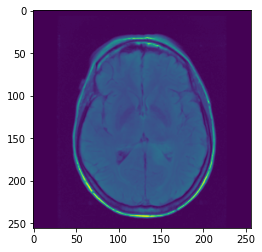

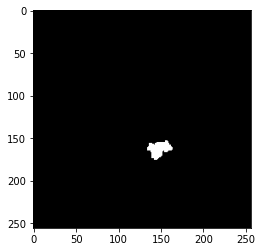

0.498993


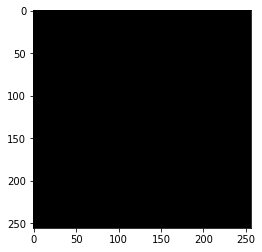

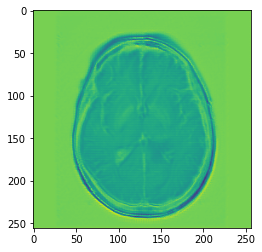

[0]


In [ ]:
preds_train = model1.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train_t = (preds_train <0.44).astype(np.uint8)
idx = 210

plt.imshow(imgs[3300+idx])
plt.show()

m_t1 = masks[3300+idx]
plt.imshow(np.dstack((m_t1,m_t1,m_t1)))
plt.show()

print(np.mean(preds_train))
m_t2 = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((m_t2,m_t2,m_t2)))
plt.show()

m_t3 = preds_train[idx]
plt.imshow(m_t3.reshape(256,256))
plt.show()
print(preds_train_t[210][100][125])

In [ ]:
print(accuracy_fun(masks[3300:len(masks)],preds_train_t))

0.8282988871224165


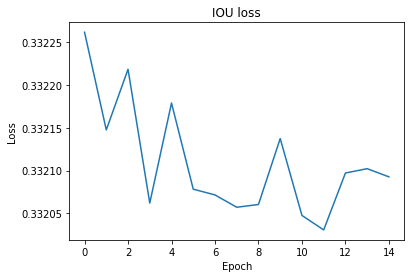

In [ ]:
plt.plot(r1.history['loss'])
plt.title('IOU loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

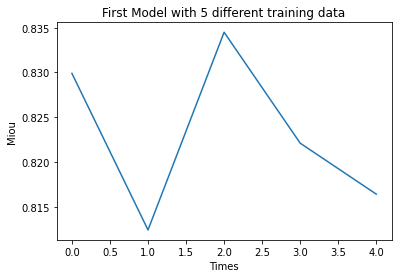

In [ ]:
l = [0.8299,0.8124,0.8345,0.8221,0.8164]

plt.plot(l)
plt.title('First Model with 5 different training data')
plt.ylabel('Miou')
plt.xlabel('Times')
plt.show()

DSC Loss with Maxpooling

In [ ]:
img_size = 256
smooth = 1
def dsc_co(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum((y_true),-1) + K.sum((y_pred),-1) - intersection + smooth)

def dsc_co_loss(y_true, y_pred):
    return 1-dsc_co(y_true, y_pred)


In [ ]:
def maxpooling_model():
  start_neurons=16
  inputs = Input((256, 256,1))
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)

  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)

  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)

  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)

  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])

  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])
  model.compile(optimizer=Adam(lr=1e-7), loss=dsc_co_loss, metrics=[dsc_co])
  model.summary()
  return model

In [ ]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model2 = maxpooling_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('maxpooling.h5', verbose=1, save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
r2 = model2.fit(train_generator,steps_per_epoch=10,epochs=10,callbacks=[earlystopper, checkpointer])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.3299 - dice_coef: 0.6701 

10/10 [==============================] - 138s 14s/step - loss: 0.3299 - dice_coef: 0.6701
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.3300 - dice_coef: 0.6700 

10/10 [==============================] - 130s 13s/step - loss: 0.3300 - dice_coef: 0.6700
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.3301 - dice_coef: 0.6699 

10/10 [==============================] - 132s 13s/step - loss: 0.3301 - dice_coef: 0.6699
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.3301 - dice_coef: 0.6699 

10/10 [==============================] - 135s 14s/step - loss: 0.3301 - dice_coef: 0.6699
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.3290 - dice_coef: 0.6710 

10/10 [==============================] - 131s 13s/step - loss: 0.3290 - dice_coef: 0.6710
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.3302 - dice_coef: 0.6698 

10/10 [==============================] - 132s 13s/step - loss: 0.3302 - dice_coef: 0.6698
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.3297 - dice_coef: 0.6703 

10/10 [==============================] - 130s 13s/step - loss: 0.3297 - dice_coef: 0.6703
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.3296 - dice_coef: 0.6704 

10/10 [==============================] - 136s 14s/step - loss: 0.3296 - dice_coef: 0.6704
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.3289 - dice_coef: 0.6711 

10/10 [==============================] - 129s 13s/step - loss: 0.3289 - dice_coef: 0.6711
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.3303 - dice_coef: 0.6697 

10/10 [==============================] - 132s 13s/step - loss: 0.3303 - dice_coef: 0.6697


20/20 [==============================] - 63s 3s/step


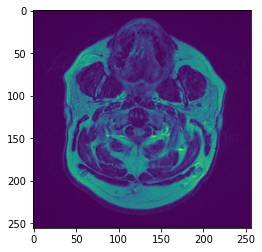

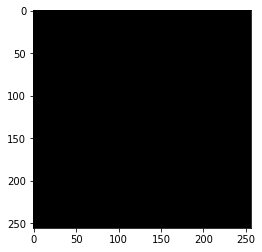

0.4996778


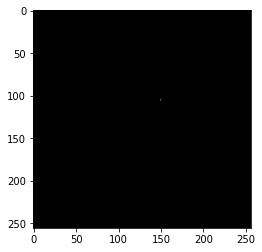

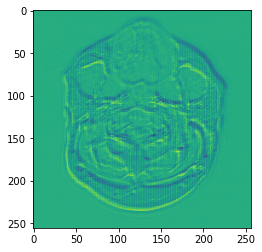

[0]


In [ ]:
preds_train = model2.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train_t = (preds_train <0.488).astype(np.uint8)
idx = 210

plt.imshow(imgs[3300+idx])
plt.show()

m_t1 = masks[3300+idx]
plt.imshow(np.dstack((m_t1,m_t1,m_t1)))
plt.show()
print(np.mean(preds_train))
m_t2 = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((m_t2,m_t2,m_t2)))
plt.show()
m_t3 = preds_train[idx]
plt.imshow(m_t3.reshape(256,256))
plt.show()
print(preds_train_t[210][100][125])

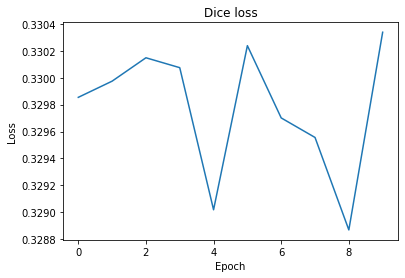

In [ ]:
plt.plot(r2.history['loss'])
plt.title('Dice loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print(accuracy_fun(masks[3300:len(masks)],preds_train_t))

0.8211246872278194


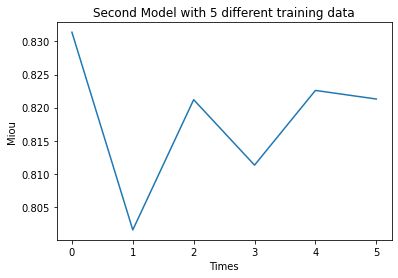

In [ ]:
l = [0.8314,0.8015,0.8212,0.8113,0.8226,0.8213]

plt.plot(l)
plt.title('Second Model with 5 different training data')
plt.ylabel('Miou')
plt.xlabel('Times')
plt.show()

Binary Cross Entropy

In [ ]:
def bce_model():
  start_neurons=16
  inputs = Input((256, 256,1))
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
  conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1)

  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
  conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
  pool2 = MaxPooling2D((2, 2))(conv2)

  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
  conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
  pool3 = MaxPooling2D((2, 2))(conv3)
  
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
  conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
  pool4 = MaxPooling2D((2, 2))(conv4)

  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
  convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

  deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
  uconv4 = concatenate([deconv4, conv4])
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
  uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

  deconv3 = Conv2DTranspose(start_neurons * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
  uconv3 = concatenate([deconv3, conv3])
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
  uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

  deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
  uconv2 = concatenate([deconv2, conv2])
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
  uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

  deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
  uconv1 = concatenate([deconv1, conv1])
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
  uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

  output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
  model = Model(inputs=[inputs], outputs=[output_layer])
  model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
from keras.callbacks import EarlyStopping
train_generator = get_augmented(X_train,Y_train)

model3 = bce_model()
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('bce.h5', verbose=1, save_best_only=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
r3 = model3.fit(train_generator,steps_per_epoch=10,epochs=10,callbacks=[earlystopper, checkpointer])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.8145 

10/10 [==============================] - 131s 13s/step - loss: 0.6920 - accuracy: 0.8145
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.9862 

10/10 [==============================] - 131s 13s/step - loss: 0.6859 - accuracy: 0.9862
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.9895 

10/10 [==============================] - 128s 13s/step - loss: 0.6722 - accuracy: 0.9895
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.9880 

10/10 [==============================] - 131s 13s/step - loss: 0.5559 - accuracy: 0.9880
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9889 

10/10 [==============================] - 137s 13s/step - loss: 0.1914 - accuracy: 0.9889
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9895 

10/10 [==============================] - 132s 13s/step - loss: 0.1289 - accuracy: 0.9895
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9879 

10/10 [==============================] - 134s 13s/step - loss: 0.1169 - accuracy: 0.9879
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9876 

10/10 [==============================] - 133s 13s/step - loss: 0.0956 - accuracy: 0.9876
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9890 

10/10 [==============================] - 130s 13s/step - loss: 0.0699 - accuracy: 0.9890
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9890 

10/10 [==============================] - 120s 12s/step - loss: 0.0567 - accuracy: 0.9890


20/20 [==============================] - 66s 3s/step


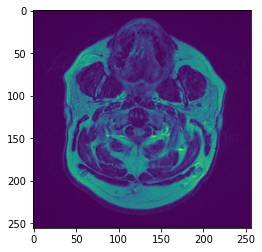

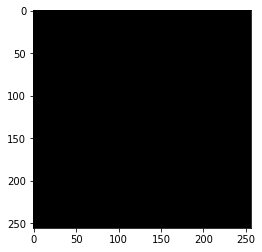

0.012899812


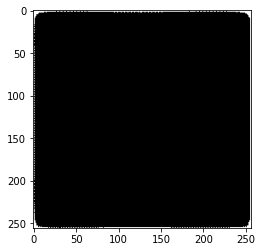

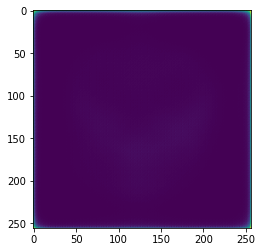

[0]


In [ ]:
preds_train = model3.predict(X_test[:int(X_train.shape[0]*0.9)], verbose=1)
preds_train_t = (preds_train >0.1).astype(np.uint8)
idx = 210

plt.imshow(imgs[3300+idx])
plt.show()

m_t1 = masks[3300+idx]
plt.imshow(np.dstack((m_t1,m_t1,m_t1)))
plt.show()

print(np.mean(preds_train))
m_t2 = np.squeeze(preds_train_t[idx]).astype(np.float32)
plt.imshow(np.dstack((m_t2,m_t2,m_t2)))
plt.show()
m_t3 = preds_train[idx]
plt.imshow(m_t3.reshape(256,256))
plt.show()
print(preds_train_t[210][100][125])

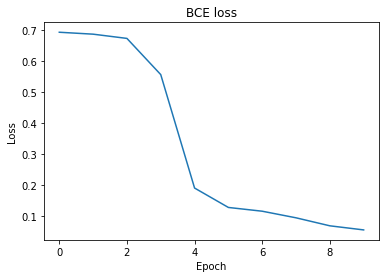

In [ ]:
plt.plot(r3.history['loss'])
plt.title('BCE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print(accuracy_fun(masks[3300:len(masks)],preds_train_t))

0.802609327164129


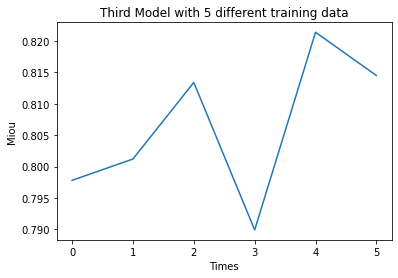

In [ ]:
l = [0.7978,0.8012,0.8134,0.7899,0.8214,0.8145]

plt.plot(l)
plt.title('Third Model with 5 different training data')
plt.ylabel('Miou')
plt.xlabel('Times')
plt.show()